In [1]:
# This code has been run on the kaggle kernel so importing files for usage locally can be done using simple input output code.
#Importing all the important libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import re
import csv
import string
import itertools
import pandas as pd
from scipy import sparse
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

stop_words = set(stopwords.words("english"))


/kaggle/input/train_stances.csv
/kaggle/input/train_bodies.csv


In [3]:
#Importing files
article = pd.read_csv("../input/train_bodies.csv")
stance = pd.read_csv("../input/train_stances.csv")

In [4]:
article.sort_values('Body ID',inplace=True)

In [5]:
article.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


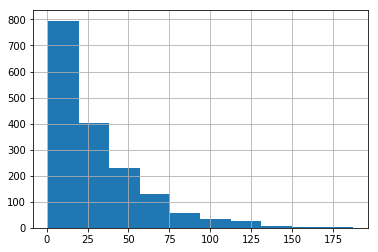

1921    187
1948    175
40      172
524     171
1549    166
304     154
1385    151
125     145
2367    143
220     141
Name: Body ID, dtype: int64

In [6]:
# For each body_id this is is distribution of headlines being generated
stance['Body ID'].value_counts().hist()
plt.show()
stance['Body ID'].value_counts().head(10)

In [7]:
# Combining data into one dataframe
body=stance['Body ID'].value_counts()

In [8]:
#Creating copy of data
art=article.copy()

In [9]:
stance.sort_values('Body ID',inplace=True)
art.set_index(keys='Body ID',inplace=True,drop=False)
stance['article']=str(0)
stance.reset_index(inplace=True,drop=True)
stance.head()
for i in stance.index:
    if stance.at[i,'Body ID'] in art['Body ID']:
        stance.at[i,'article']=art.at[stance.at[i,'Body ID'],'articleBody']
stance.to_csv("prepared.csv",index=False)
st=stance.copy()
#Preprocessing data
st['Headline']=st['Headline'].apply(lambda x: x.lower())
st['article']=st['article'].apply(lambda x: x.lower())
#lemmatizing data
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()



In [10]:
#Creating data for TFIDF branch by concatenating articles and headliens
st['art_head']=st['article']+' '+st['Headline']  
st = st.sample(frac=1).reset_index(drop=True)

In [11]:
#Preprocessing the data
def preprocess(s):
    preprocessed=[]
    for i in range( 0, s.size ):
        #X_train.append(train_data['text'][i])    # Appending train data
        rowstring = []
        tokens = (s[i]).split()
        tokens = filter(lambda x: x not in string.punctuation, tokens)   # Remove punctuation
        cleaned_text = filter(lambda x: x not in stop_words, tokens)    #Remove stopwords
        for tok in cleaned_text:
            if '#' in tok:
                tok = tok[1:len(tok)]
                rowstring.append(tok)
            elif '@' not in tok and 'http' not in tok and 'RT' not in tok and 'amp' not in tok and '&lt' not in tok:  #  Remove words with '@','#' and 'http' symbol
                rowstring.append(tok)
        cleaned_withascii_rowstring = " ".join(rowstring)
        cleaned_rowstring=''.join([x for x in cleaned_withascii_rowstring if ord(x) < 128])
        letters_only = re.sub("[^a-zA-Z]", " ", cleaned_rowstring)      # Letter Only
        re_tokens =letters_only.lower().split()                         # Make all the words in lower case
        re_cleaned_rowstring = " ".join(re_tokens)
        preprocessed.append(re_cleaned_rowstring)
    preprocessed=list(map(lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)],preprocessed))
    return preprocessed

In [12]:
headlines=preprocess(st['Headline'])
articles=preprocess(st['article'])
art_head=preprocess(st['art_head'])

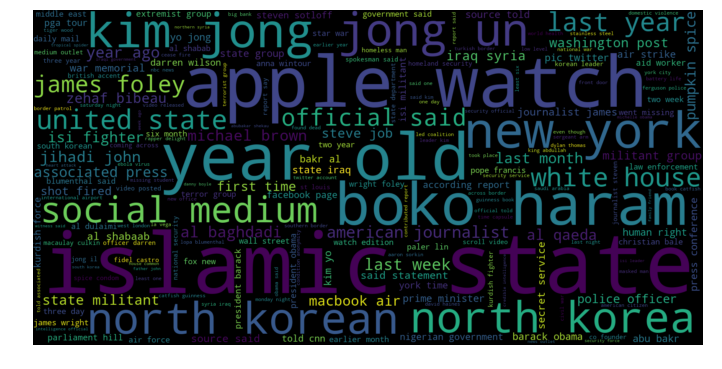

In [13]:
# Word cloud for articles
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(' '.join(list(map(lambda x: ' '.join(x),articles))))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

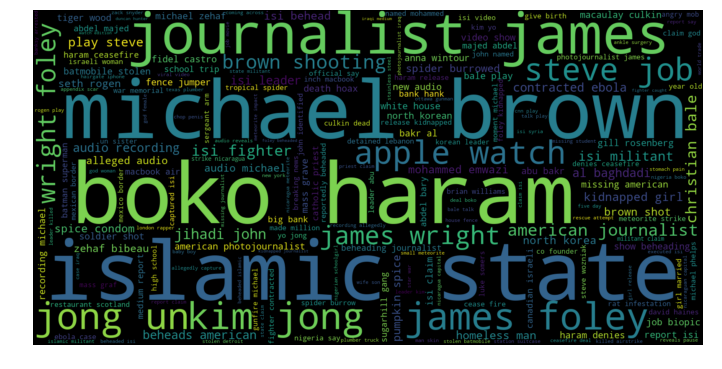

In [14]:
# Word cloud for headlines
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(' '.join(list(map(lambda x: ' '.join(x),headlines))))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [15]:
stances=st['Stance']

In [16]:
# Annotation for stance: unrelated=1,discuss=2, agree=3, disagree=4
for i in range(len(stances)):
    if stances[i]=='unrelated':
        stances[i]=0
    elif stances[i]=='discuss':
        stances[i]=1
    elif stances[i]=='agree':
        stances[i]=2
    elif stances[i]=='disagree':
        stances[i]=3


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: Setting

In [17]:
from keras.utils import to_categorical
stances=np.array(stances)
stances=to_categorical(stances)

Using TensorFlow backend.


In [18]:
# TFIDF transformation for article and headline concatenated data
X_concat=TfidfVectorizer().fit_transform(list(map(lambda x:' '.join(x),art_head)))

Train on 45972 samples, validate on 4000 samples
Epoch 1/100
45972/45972 [==============================] - 6s 129us/step - loss: 0.6366 - accuracy: 0.7711 - val_loss: 0.5473 - val_accuracy: 0.8005
Epoch 2/100
45972/45972 [==============================] - 6s 123us/step - loss: 0.5207 - accuracy: 0.8126 - val_loss: 0.4948 - val_accuracy: 0.8232
Epoch 3/100
45972/45972 [==============================] - 7s 144us/step - loss: 0.4839 - accuracy: 0.8259 - val_loss: 0.4759 - val_accuracy: 0.8300
Epoch 4/100
45972/45972 [==============================] - 6s 126us/step - loss: 0.4631 - accuracy: 0.8353 - val_loss: 0.4692 - val_accuracy: 0.8403
Epoch 5/100
45972/45972 [==============================] - 6s 123us/step - loss: 0.4436 - accuracy: 0.8423 - val_loss: 0.4573 - val_accuracy: 0.8438
Epoch 6/100
45972/45972 [==============================] - 6s 124us/step - loss: 0.4212 - accuracy: 0.8517 - val_loss: 0.4115 - val_accuracy: 0.8565
Epoch 7/100
45972/45972 [==============================] 

45972/45972 [==============================] - 7s 148us/step - loss: 0.1935 - accuracy: 0.9390 - val_loss: 0.2603 - val_accuracy: 0.9110
Epoch 56/100
45972/45972 [==============================] - 6s 138us/step - loss: 0.1919 - accuracy: 0.9371 - val_loss: 0.2288 - val_accuracy: 0.9222
Epoch 57/100
45972/45972 [==============================] - 6s 131us/step - loss: 0.1927 - accuracy: 0.9382 - val_loss: 0.2377 - val_accuracy: 0.9190
Epoch 58/100
45972/45972 [==============================] - 6s 138us/step - loss: 0.1919 - accuracy: 0.9387 - val_loss: 0.2464 - val_accuracy: 0.9170
Epoch 59/100
45972/45972 [==============================] - 7s 142us/step - loss: 0.1894 - accuracy: 0.9401 - val_loss: 0.2276 - val_accuracy: 0.9202
Epoch 60/100
45972/45972 [==============================] - 6s 133us/step - loss: 0.1901 - accuracy: 0.9385 - val_loss: 0.2280 - val_accuracy: 0.9235
Epoch 61/100
45972/45972 [==============================] - 6s 138us/step - loss: 0.1894 - accuracy: 0.9401 - val

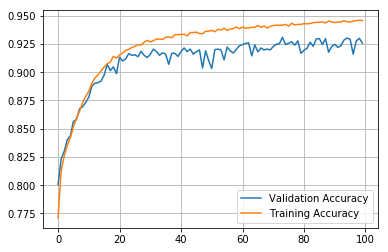

In [20]:
#Building a simple multi-classification model using fully connected layer
from keras import models
from keras import layers
from keras.datasets import imdb
from keras.utils  import to_categorical
from keras import optimizers
#!pip install numpy==1.16.1     -if using google colab
from keras import metrics 
from keras import losses
from keras.callbacks import EarlyStopping

#Case 1 - Training on optimal network capacity
X_val=X_concat[:4000]
X_tr=X_concat[4000:]
Y_val=stances[:4000]
Y_tr=stances[4000:]
mod=models.Sequential()
layers.ActivityRegularization(l1=0.0, l2=0.0001)
mod.add(layers.Dense(64,activation='relu',input_shape=(20115,)))
mod.add(layers.Dropout(.2))
mod.add(layers.Dense(32,activation='relu'))
mod.add(layers.Dense(16,activation='relu'))
mod.add(layers.Dense(4,activation='softmax'))
mod.compile(loss=losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy']) 
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=.5)
history=mod.fit(X_tr,Y_tr,epochs=100,batch_size=64,validation_data=(X_val,Y_val))
val_orig=history.history['val_accuracy']
accuracy=history.history['accuracy']
plt.plot(val_orig,label='Validation Accuracy')
plt.plot(accuracy,label='Training Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
#Plotting loss function

plt.plot(history.history['val_loss'],label='Validation loss')
plt.plot(history.history['loss'],label='Training loss')
plt.legend(loc='best')
plt.grid()
plt.show()

This TFIDF model is underfitted but has given us a good accuracy on training data.

In [21]:
# Using functional API of Keras for multi-input model
from keras.models import Sequential, Model 
from keras import layers 
from keras import Input
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences



In [22]:
tokenizer = Tokenizer(num_words=20000, split=' ')
tokenizer.fit_on_texts(articles)
X_art = tokenizer.texts_to_sequences(articles)
X_art = pad_sequences(X_art)

tokenizer = Tokenizer(num_words=10000, split=' ')
tokenizer.fit_on_texts(headlines)
X_head = tokenizer.texts_to_sequences(headlines)
X_head = pad_sequences(X_head)




In [23]:
X_art_val=X_art[:2000]
X_art_train=X_art[2000:10000]

X_head_val=X_head[:2000]
X_head_train=X_head[2000:10000]

Y_val=stances[:2000]
Y_train=stances[2000:10000]

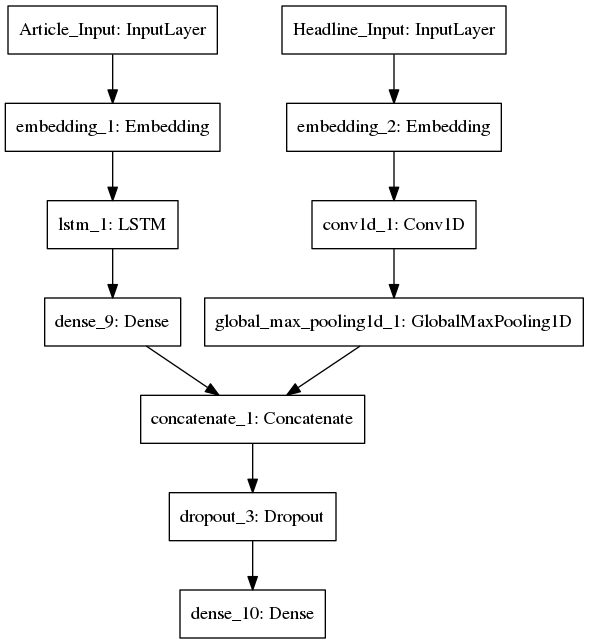

In [24]:
#Designing architecture
embedding_size_art=128
article_input=Input(shape=[None,],name='Article_Input')
embedding_art=layers.Embedding(20000,128)(article_input)
lstm_art=layers.LSTM(32)(embedding_art)   #using LSTMs for articles for long term understanding of articles
dense1=layers.Dense(32,activation='relu')(lstm_art)

headline_input=Input(shape=[None,],name='Headline_Input')
embedding_art=layers.Embedding(10000,128)(headline_input)
cnn_art=layers.Conv1D(32,5,activation='relu')(embedding_art)   #using 1D CNNs for better understanding of local patterns in headline
#max_pool=layers.MaxPooling1D(5)(cnn_art)
max_pool=layers.GlobalMaxPooling1D()(cnn_art)
#dense2=layers.Dense(8,activation='relu')(max_pool)

concatenated=layers.concatenate([dense1,max_pool],axis=-1)    #Concatenating the text
dropout=layers.Dropout(.2)(concatenated)
output_stance=layers.Dense(4,activation='softmax')(dropout)

model=Model([article_input,headline_input],output_stance)

plot_model(model)


In [ ]:
model.compile(loss=losses.categorical_crossentropy,optimizer='rmsprop',metrics=['accuracy']) 
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1)
history=model.fit([X_art_train,X_head_train],Y_train,epochs=10,batch_size=64,validation_data=([X_art_val,X_head_val],Y_val))
val_orig=history.history['val_accuracy']
accuracy=history.history['accuracy']
plt.plot(val_orig,label='Validation Accuracy')
plt.plot(accuracy,label='Training Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 465s 58ms/step - loss: 0.7876 - accuracy: 0.7345 - val_loss: 0.7029 - val_accuracy: 0.7610
Epoch 2/10
8000/8000 [==============================] - 450s 56ms/step - loss: 0.6230 - accuracy: 0.7886 - val_loss: 0.6549 - val_accuracy: 0.7780
Epoch 3/10
8000/8000 [==============================] - 451s 56ms/step - loss: 0.5571 - accuracy: 0.8073 - val_loss: 0.6440 - val_accuracy: 0.7680
Epoch 4/10
8000/8000 [==============================] - 449s 56ms/step - loss: 0.5082 - accuracy: 0.8206 - val_loss: 0.6128 - val_accuracy: 0.7810
Epoch 5/10
8000/8000 [==============================] - 448s 56ms/step - loss: 0.4662 - accuracy: 0.8317 - val_loss: 0.6061 - val_accuracy: 0.7845
Epoch 6/10
8000/8000 [==============================] - 446s 56ms/step - loss: 0.4174 - accuracy: 0.8504 - val_loss: 0.5987 - val_accuracy: 0.7870
Epoch 7/10
8000/8000 [==============================] - 444s 56ms/step